In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
!unzip /content/drive/MyDrive/chest_xray.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg  


In [5]:
# ======================================================
# Chest X-Ray Dataset Directories
# ======================================================
# Path to the training dataset (images organized in class subfolders)
train_dir = "/content/chest_xray/train"

# Path to the testing dataset (images organized in class subfolders)
test_dir  = "/content/chest_xray/test"


In [6]:
from torchvision import transforms

In [7]:
custom_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=15, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.1))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to match input size
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])  # Same normalization as train
])



In [8]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset,DataLoader

class Custom_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']

        self.images_path = []
        self.labels = []

        for label, cls in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, cls)
            for file in os.listdir(class_dir):
                self.images_path.append(os.path.join(class_dir, file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [9]:
train_dataset = Custom_dataset(train_dir, transform=custom_transform)
test_dataset = Custom_dataset(test_dir, transform=test_transform)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# fetch the pretrained model

import torchvision.models as models

efficientnet = models.efficientnet_b3(pretrained=True)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 127MB/s]


In [12]:
import torch.nn as nn


In [13]:
for name, param in efficientnet.named_parameters():
    if  "classifier" in name:  # last norm + classifier
        param.requires_grad = True
    else:
        param.requires_grad = False


In [14]:
num_features = efficientnet.classifier[1].in_features
print("in_features:", num_features)


in_features: 1536


In [15]:
efficientnet.classifier = nn.Sequential(
    nn.Linear(num_features, 1536),  # first hidden layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1536, 2)          # output layer for 2 classes
)



In [16]:
efficientnet = efficientnet.to(device)

In [17]:
from torch import optim

In [18]:
learning_rate=1e-4

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientnet.parameters()),
    lr=learning_rate,
    weight_decay=1e-4
)


In [20]:
# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',     # Reduce LR when the monitored quantity (loss) stops decreasing
    factor=0.1,     # Reduce LR by a factor of 0.1
    patience=2      # Wait for 2 epochs with no improvement before reducing LR
)


In [21]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        """
        patience: epochs without improvement after which training stops
        min_delta: minimum change in val_loss to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter if improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


Epoch [1/10] | Train Loss: 0.3497 | Val Loss: 0.4108 | Val Acc: 81.89% | LR: 0.000100
Epoch [2/10] | Train Loss: 0.2216 | Val Loss: 0.3356 | Val Acc: 85.74% | LR: 0.000100
Epoch [3/10] | Train Loss: 0.2147 | Val Loss: 0.3053 | Val Acc: 87.02% | LR: 0.000100
Epoch [4/10] | Train Loss: 0.1959 | Val Loss: 0.3001 | Val Acc: 87.66% | LR: 0.000100
Epoch [5/10] | Train Loss: 0.1907 | Val Loss: 0.2996 | Val Acc: 88.30% | LR: 0.000100
Epoch [6/10] | Train Loss: 0.1882 | Val Loss: 0.2990 | Val Acc: 87.82% | LR: 0.000100
Epoch [7/10] | Train Loss: 0.1837 | Val Loss: 0.2912 | Val Acc: 88.46% | LR: 0.000100
Epoch [8/10] | Train Loss: 0.1823 | Val Loss: 0.2995 | Val Acc: 88.62% | LR: 0.000100
Epoch [9/10] | Train Loss: 0.1751 | Val Loss: 0.3044 | Val Acc: 88.14% | LR: 0.000100
Epoch [10/10] | Train Loss: 0.1826 | Val Loss: 0.3048 | Val Acc: 88.14% | LR: 0.000010
Early stopping triggered!


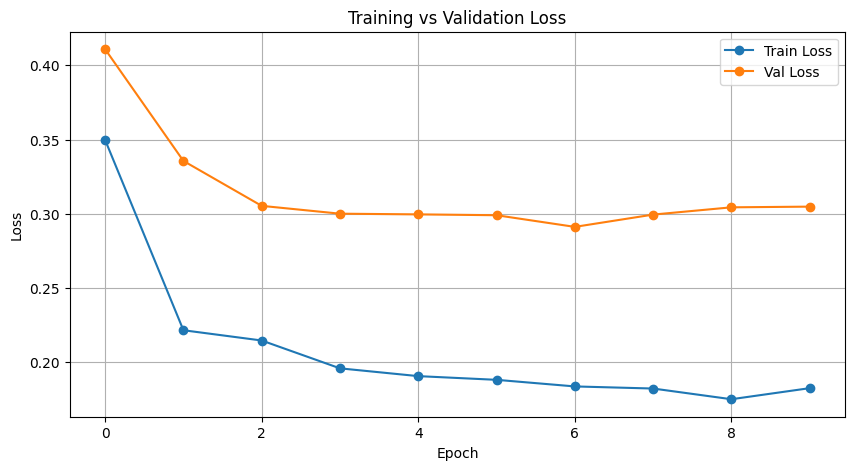

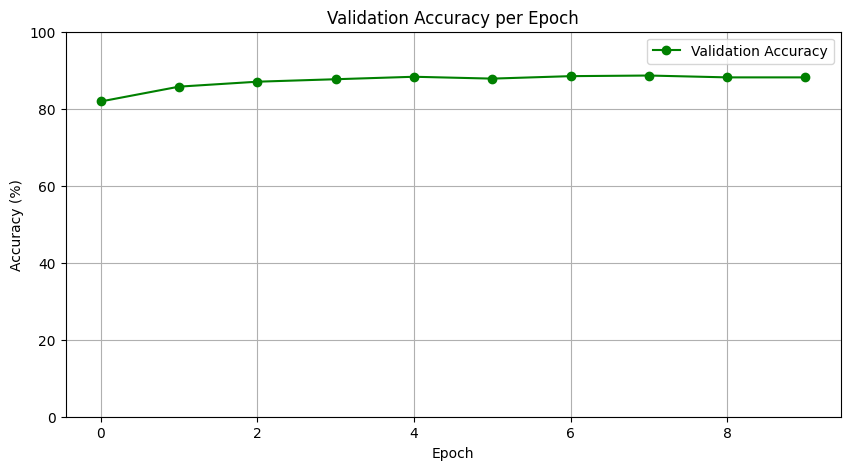

In [22]:
import matplotlib.pyplot as plt
import os

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Lists to store metrics per epoch
train_losses = []
val_losses = []
val_accuracies = []

epochs = 10
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

for epoch in range(epochs):
    # ========== Training ==========
    efficientnet.train()
    total_train_loss = 0.0

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = efficientnet(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ========== Validation ==========
    efficientnet.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.squeeze().long().to(device)

            outputs = efficientnet(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    # ========== Scheduler & Early Stopping ==========
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | LR: {optimizer.param_groups[0]['lr']:.6f}")

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# ========================== Plot & Save Loss Curve ==========================
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig("results/loss_curve.png")  # Save figure
plt.show()

# ========================== Plot & Save Accuracy Curve ==========================
plt.figure(figsize=(10,5))
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy per Epoch')
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.savefig("results/val_accuracy.png")  # Save figure
plt.show()


In [ ]:
img_path = "/content/chest_xray/chest_xray/test/NORMAL/IM-0009-0001.jpeg"
image = Image.open(img_path).convert("RGB")  # efficientnet expects RGB
image = test_transform(image).unsqueeze(0)  # add batch dimension
image = image.to(device)  # GPU if available


In [31]:
with torch.no_grad():
    outputs = efficientnet(image)
    _, predicted = torch.max(outputs, 1)

classes = ['NORMAL', 'PNEUMONIA']
print("Predicted Class:", classes[predicted.item()])


Predicted Class: NORMAL


In [32]:
torch.save(efficientnet.state_dict(), "best_model.pth")
